In [1]:
from function.VAE import *
import matplotlib.pyplot as plt 
from IPython.display import clear_output #

In [57]:
from sklearn.model_selection import GridSearchCV
import openturn_sampling as ot 

In [3]:
dim = 10
N = 10000

#### Une composante avec une variance et une moyenne différentes de celles des autres composantes

In [4]:
uncentered_gaussian = np.random.normal(loc= 5, scale=2 , size=N)
dist = np.random.normal(size= (N, dim-1))
dist = np.hstack((uncentered_gaussian.reshape(-1,1), dist))
dist.shape

(10000, 10)

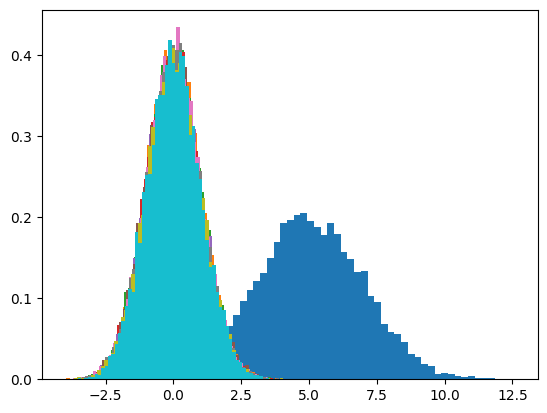

In [5]:
for i in range(dim):
    plt.hist(dist[:, i],bins= 'auto', density=True, label= r'$density_%d$'%i);

In [31]:
encoder = Encoder(input_dim= dim, latent_dim=2)
decoder = Decoder(input_dim= dim, latent_dim=2)
vae = VAE(encoder, decoder)######## Training #########
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0004))
history = vae.fit(dist,epochs=150, batch_size=100, shuffle=True)

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.5459 - loss: 15.7767 - reconstruction_loss: 15.2308
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 1.0961 - loss: 8.0576 - reconstruction_loss: 6.9615
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.6817 - loss: 7.2804 - reconstruction_loss: 6.5987
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.4557 - loss: 6.7270 - reconstruction_loss: 6.2712
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.2186 - loss: 6.1722 - reconstruction_loss: 5.9536
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.1338 - loss: 5.9725 - reconstruction_loss: 5.8387
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.1030 - loss: 5.8082 - reconstruction_loss: 5.7051
Epoch 8/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0846 - loss: 5.7818 - reconstruction_loss: 5.6973
Epoch 9/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0687

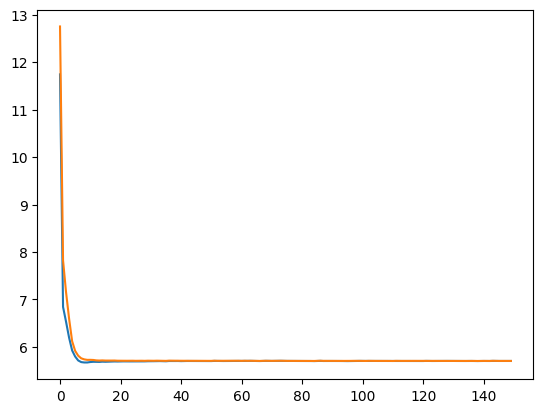

In [32]:
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['loss'])

In [33]:
_, _, z = encoder(dist)
reconstruction, log_var_x = decoder(z)

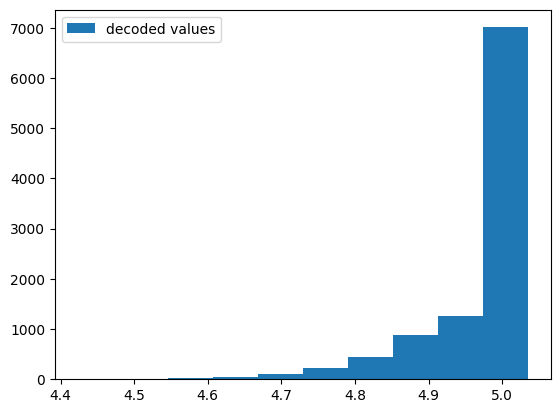

In [34]:
plt.hist(reconstruction[:,0], label = 'decoded values');
plt.legend();

In [35]:
X_hat = np.random.normal(loc= reconstruction, scale=tf.exp(log_var_x/2))
X_hat.shape

(10000, 10)

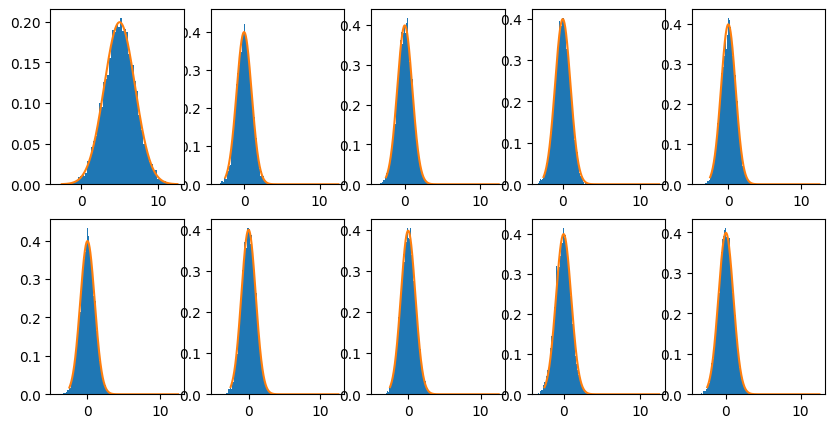

In [45]:
#plt.scatter(z[:, 0], z[:, 1])
plt.figure(figsize=(10,5))
col = int(dim/2)
xx = np.linspace(-2.5, 12.5, 1000)
for i in range(1,dim):
    plt.subplot(2, col, i+1)
    plt.hist(X_hat[:,i], density=True, bins = 'auto');
    plt.plot(xx, sp.norm.pdf(xx))
plt.subplot(2, col, 1)
plt.hist(X_hat[:,0], density=True, bins = 'auto');
plt.plot(xx, sp.norm.pdf(xx, loc = 5, scale =2))

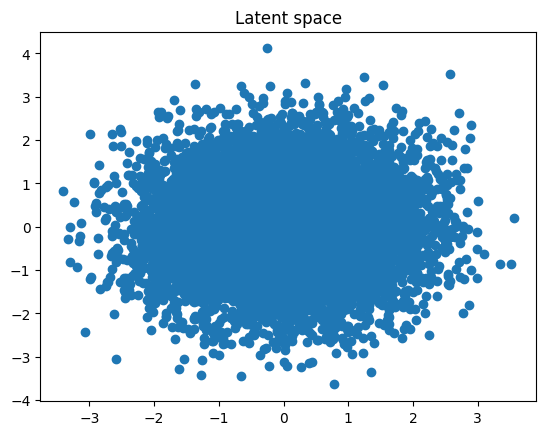

In [46]:
plt.scatter(z[:, 0], z[:, 1]);
plt.title("Latent space");

In [47]:
print(f"Moyenne empirique pour la 1er composante {np.round(np.mean(reconstruction, axis=0), 1)}")
print(f"Moyenne empirique pour la 1er composante {np.round(np.mean(np.exp(log_var_x), axis=0), 1)}")

Moyenne empirique pour la 1er composante [ 5.  0. -0. -0. -0.  0.  0. -0. -0.  0.]
Moyenne empirique pour la 1er composante [4.1 1.  1.  1.  1.  1.  1.  1.  1.  1. ]


### Première composante, un gaussienne tronquée et les autres composantes des gaussiennes standard

In [48]:
#Simulation of a truncated normal distribution 
def truncatedDistribution(n_samples,  mean, variance,  bound):
    sd = np.sqrt(variance)
    L = list()
    i = 0 
    while i < n_samples:
        prop = np.random.normal(loc = mean, scale=sd)
        #prop_norm = np.linalg.norm(prop[0:2], ord=-np.inf)

        if prop[0] > bound : 
            L.append(prop)
            i += 1
            if i %10 == 0:
                clear_output(wait=True)
                print("boucle %d terminée" %(i))

    return np.array(L)

In [49]:
dist = truncatedDistribution(10000, np.zeros(dim), np.ones(dim), 2 )
dist_scaled = (dist - dist.mean(axis=0)) / np.std(dist, axis=0)

boucle 10000 terminée


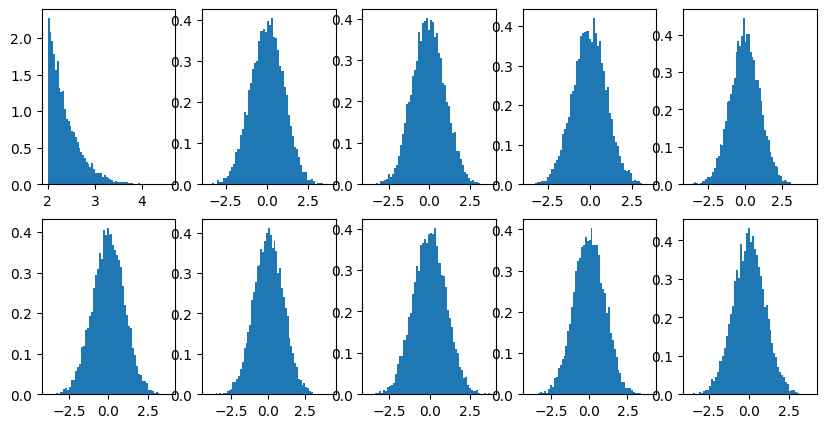

In [52]:
plt.figure(figsize= (10, 5))
for i in range(dim):
    plt.subplot(2, col, i+1)
    plt.hist(dist[:, i], density= True, bins='auto');

In [53]:
encoder = Encoder(input_dim=dim, latent_dim=2)
decoder = Decoder(input_dim=dim, latent_dim=2)
vae = VAE(encoder, decoder)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3))
vae.fit(dist, epochs= 100, batch_size=100)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.1166 - loss: 6.6687 - reconstruction_loss: 6.5521
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0212 - loss: 4.9094 - reconstruction_loss: 4.8882
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0142 - loss: 4.3533 - reconstruction_loss: 4.3391
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0095 - loss: 3.9180 - reconstruction_loss: 3.9085
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0071 - loss: 3.9130 - reconstruction_loss: 3.9059
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0056 - loss: 3.9678 - reconstruction_loss: 3.9622
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0041 - loss: 3.9046 - reconstruction_loss: 3.9006
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0038 - loss: 3.9217 - reconstruction_loss: 3.9179
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.0027 -

In [54]:
mean_z, log_var_z, z = encoder(dist)
mean_x, log_var_x = decoder(z)

samples = np.random.normal(loc= mean_x, scale= tf.exp(log_var_x /2))
samples.shape

(10000, 10)

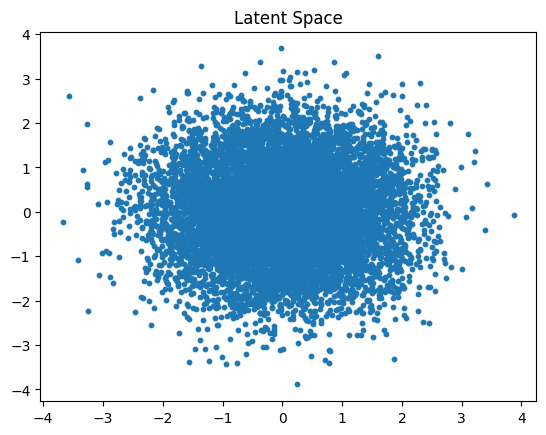

In [56]:
plt.scatter(z[:, 0], z[:, 1], s= 10)
plt.title("Latent Space");

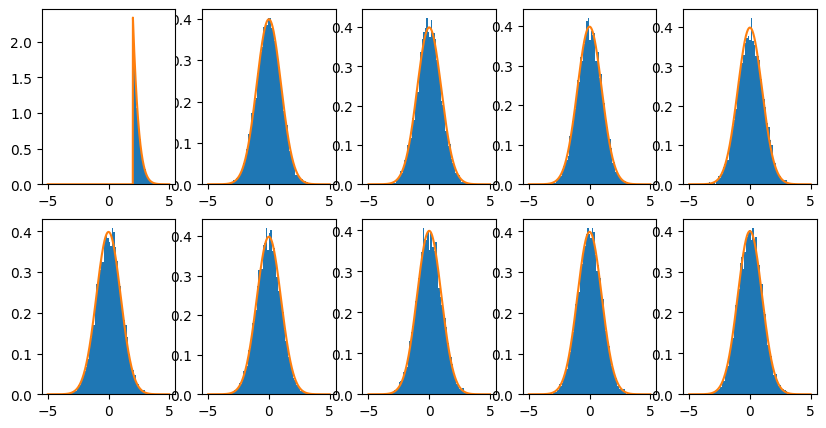

In [67]:
plt.figure(figsize=(10,5))
col = int(dim/2)
xx = np.linspace(-5,5, 1000)
distr1 = ot.TruncatedDistribution(ot.Normal(1), 2, ot.TruncatedDistribution.LOWER)
for i in range(1,dim):
    plt.subplot(2, col, i+1)
    plt.hist(samples[:,i], density=True, bins = 'auto');
    plt.plot(xx, sp.norm.pdf(xx))
plt.subplot(2, col, 1)
plt.hist(samples[:,0], density=True, bins = 'auto');
plt.plot(xx, distr1.computePDF(xx.reshape((-1,1))))

In [78]:
print(f"La moyenne empirique de la  1er composante {np.mean(mean_x, axis=0)[0]} et la moyenne théorique  {sp.norm.pdf(2)/(1-sp.norm.cdf(2))}" )
print(f"variance empirique {np.mean(tf.exp(log_var_x/2), axis = 0 )[0]}, moyenne théorique {np.sqrt(1 - sp.norm.pdf(2)/(1-sp.norm.cdf(2)) * (sp.norm.pdf(2)/(1-sp.norm.cdf(2)) - 2))}")

La moyenne empirique de la  1er composante 2.378115177154541 et la moyenne théorique  2.373215532822841
variance empirique 0.10744918137788773, moyenne théorique 0.33805191970181275


Reproduction de la troncature sur la 1er composante fidèle en moyenne, cependant le compromis régularisation, précision est difficile à controler ici. Très difficile d'arriver à trouver les hyperparamètres qui permettent de ne pas se concentrer seulement sur la $D_{KL}$.

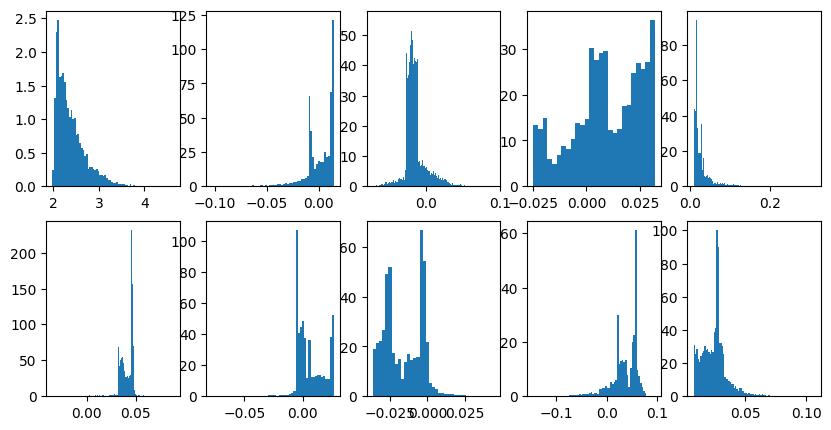

In [68]:
plt.figure(figsize= (10, 5))
for i in range(dim):
    plt.subplot(2, int(dim/2), i+1)
    plt.hist(mean_x[:, i], density=True, bins='auto')

In [83]:
print(f"variance des valeurs log-variance renvoyées par le NN {np.var(log_var_x)}")

variance des valeurs log-variance renvoyées par le NN 1.9941688776016235


In [32]:
tf.reduce_mean(0.5*(tf.reduce_sum((dist-mean_x)/log_var_x, axis=1)))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.7373258>